# Style Transfer 
Implementation of original style tranfer paper (https://arxiv.org/abs/1508.06576) with improved losses from https://arxiv.org/abs/1603.08155


In [142]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import imagenet_utils
from keras import backend as K
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, HTML
from IPython.display import display, Image
from functools import partial
import utils
reload(utils)
from utils import *
from IPython.core.debugger import Tracer
from display_graph import display_graph
import pprint
import time
from scipy.misc import imsave

%matplotlib inline

## Image loading and generating routines

In [143]:
# Output image size
image_size = (300, 300)

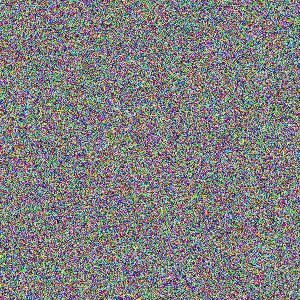

In [144]:
def random_image(size,):
    '''Generate a random noise image and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            random_noise: Whether to generate a random noise 
             image or to load a picture.
            filename: The fullpath to the image to load.
    '''
    width, height = size
    # Generate a random noise image
    # 3 is the number of channels (RGB) in the image.
    img = np.random.random(size=(width, height, 3))
    img_array = img * 256
    return img_array


def load_image(size, filename=None):
    '''Load image from disc and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            filename: The fullpath to the image to load.
    '''
    width, height = size

    if not filename:
        raise ValueError(
            'If not generating random noise image, image filename is required.')
    # Load a picture
    img = PIL.Image.open(filename)
    img = img.resize((width, height))
    img_array = np.asarray(img.copy())
    return img_array

# Get and displaying image
image = random_image(size=image_size)
show(image)

## Load model

In [145]:
graph = tf.Graph()
config = tf.ConfigProto()
# Uncomment this if you want to use two iPython scripts side by side,
# and you dont want tensorflow to take up all the GPU memory on initialization
# config.gpu_options.allow_growth=True

# Interactive session is better suited for notebooks
sess = tf.InteractiveSession(graph=graph, config=config)
K.set_session(sess)

# Keras flag - we are not training, just testing now
K.set_learning_phase(0)


def setup_model(initial_value, model_name='Inception5h'):
    '''Load the model. Use a TF tensor as input just for fun.
    Args: 
        initial_value: The initial value of the input tensor. Mainly used for size.
        model_name: Whether to normalize the input image.
    Returns:
        Tuple of (model, # The loaded keras model
            input_tensor, # The tensor that feeds the model
            content_layers, # The content layers of this model as tensors
            style_layers, # The style layers of this model as tensors
            preprocess_func, # Preprocesses an image for the model
            deprocess_func # Returns preprocessed image back to normal.
    '''
    # Prepare tensor for input image
    image_tensor = tf.Variable(initial_value)

    if model_name == 'VGG16' or model == 'VGG19':
        # These two models share a lot, so define them together
        if model_name == 'VGG16':
            # VGG 16 model
            model = VGG16(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)
        elif model_name == 'VGG19':
            model = VGG19(include_top=False, weights='imagenet',
                          input_tensor=image_tensor)

        # Preprocesses an image for the model
        def preprocess_func(x):
            x = x.copy().astype(float)
            rank = len(x.shape)
            if (rank == 3):
                # Add extra batch dimension
                x = np.expand_dims(x, axis=0)
            x[:, :, :, 2] -= 103.939
            x[:, :, :, 1] -= 116.779
            x[:, :, :, 0] -= 123.68

            # Flip the channels from RGB to BGR
            x = x[:, :, :, ::-1]
            return x

        # Returns preprocessed image back to normal.
        def deprocess_func(x):
            x = np.asarray(x).copy()
            rank = len(x.shape)
            if (rank == 4):
                # Remove extra batch dimension
                x = np.squeeze(x, axis=0)

            # Flip the channels from BGR to RGB
            x = x[:, :, ::-1]

            # Remove zero-center by mean pixel
            x[:, :, 2] += 103.939
            x[:, :, 1] += 116.779
            x[:, :, 0] += 123.68

            x = np.clip(x, 0, 255).astype('uint8')
            return x

        # Define the style layers
        style_layers = [model.get_layer('block1_conv1').output,
                        model.get_layer('block2_conv1').output,
                        model.get_layer('block3_conv1').output,
                        model.get_layer('block4_conv1').output,
                        model.get_layer('block5_conv1').output]

        # Define the content layers
        content_layers = model.get_layer('block4_conv2').output

    # TODO: Add other models

    return model, image_tensor, content_layers, style_layers, preprocess_func, deprocess_func

with graph.as_default():
    with graph.name_scope("model") as scope:
        # Use the image size (with a batch dimension) to feed the model input.
        # We do so that the input has size and the convolutional layers
        # will be sized as well.
        initial = np.expand_dims(image, axis=0).astype('float32')

        # Setup the model
        (model, input_tensor, content_layers, style_layers,
         preprocess, deprocess) = setup_model(
            initial_value=initial,
            model_name='VGG16')

In [146]:
# Checkout what we got
(model, input_tensor, content_layers, style_layers,
 preprocess, deprocess)

(<keras.engine.training.Model at 0x7f3cafb41cd0>,
 <tf.Tensor 'model/Relu_8:0' shape=(1, 37, 37, 512) dtype=float32>,
 [<tf.Tensor 'model/Relu:0' shape=(1, 300, 300, 64) dtype=float32>,
  <tf.Tensor 'model/Relu_2:0' shape=(1, 150, 150, 128) dtype=float32>,
  <tf.Tensor 'model/Relu_4:0' shape=(1, 75, 75, 256) dtype=float32>,
  <tf.Tensor 'model/Relu_7:0' shape=(1, 37, 37, 512) dtype=float32>,
  <tf.Tensor 'model/Relu_10:0' shape=(1, 18, 18, 512) dtype=float32>],
 <function __main__.preprocess_func>,
 <function __main__.deprocess_func>)

In [147]:
# Summary of the model layers
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (1, 300, 300, 3)      0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (1, 300, 300, 64)     1792        input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (1, 300, 300, 64)     36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (1, 150, 150, 64)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [148]:
# Uncomment this to print all operations in the graph so far
# print('\n'.join([op.name for op in graph.get_operations()]))

## Style transfer

### Style transfer simplest algo
1. Load the style and content images.
2. Compute the style layers activations of the style input image, 
and the content layer activations of the content input image.
3. Define Style difference between current image and style input image.
4. Define Content loss between current image and content image.
5. Define Total variance loss (prevents noise in result).
6. Define the gradient to change a result image to minimize 
the total loss = style loss + content loss + total variance loss
7. Modify the result image by the gradient
for a number of iterations.

## Step 1 
Get the style and the content image.

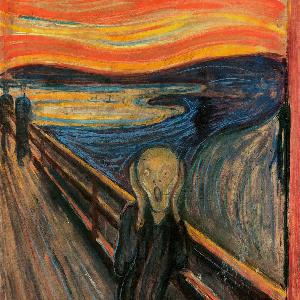

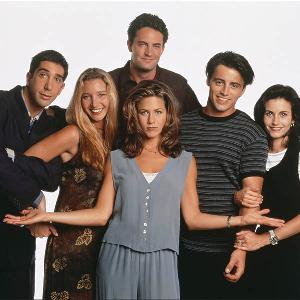

In [230]:
# Image which will define the style
style_image = load_image(size=image_size, filename='images/scream.jpg')
show(style_image)

# Image to define the content
content_image = load_image(size=image_size, filename='images/friends.jpg')
show(content_image)

## Step 1.5

To preserve color in the content image, we apply the techniques from https://arxiv.org/pdf/1606.05897.pdf. In particular, the Color Histogram matching using Image Analogies color matching.

## Step 2
Compute the style layers activations of the style input image, 
and the content layer activations of the content input image.

In [231]:
# Compute the style activations
style_layers_computed = sess.run(
    style_layers,
    feed_dict={input_tensor: preprocess(style_image)})

# Compute the content activations
content_layers_computed = sess.run(
    content_layers,
    feed_dict={input_tensor: preprocess(np.expand_dims(content_image, 0))})

## Step 3 
Difference between style layers of result image and style layers of style image

In [232]:
def style_loss(current, computed):
    '''Define the style loss between a tensor and an np array.
    Args:
        current: tf.Tensor. The style activations of the current image.
        computed: np array. The style activations of the style input image.
    '''
    style_losses = []
    for layer1, layer2 in zip(current, computed):
        _, height, width, number = map(lambda i: i, layer2.shape)
        size = height * width * number

        # Compute layer1 Gram matrix
        feats1 = tf.reshape(layer1, (-1, number))
        layer1_gram = tf.matmul(tf.transpose(feats1), feats1) / size
        # Compute layer2 Gram matrix
        feats2 = tf.reshape(layer2, (-1, number))
        layer2_gram = tf.matmul(tf.transpose(feats2), feats2) / size

        dim1, dim2 = map(lambda i: i.value, layer1_gram.get_shape())
        loss = tf.sqrt(tf.reduce_sum(
            tf.square((layer1_gram - layer2_gram) / (number * number))))
        style_losses.append(loss)
    return tf.add_n(style_losses)

## Step 4
Difference between content layers of result image and content layers of content image.

In [233]:
def content_loss(current, computed):
    # Currently only for a single layer
    _, height, width, number = computed.shape
    size = height * width * number
    return tf.sqrt(tf.nn.l2_loss(current - computed) / size)

## Step 5
Total variation loss, designed to keep the generated image locally coherent.
https://en.wikipedia.org/wiki/Total_variation_denoising


In [234]:
def total_variation_loss(image, image_shape=None):
    if image_shape:
        width, height, channels = image_shape
    else:
        # Try to get the image size from the tensor
        dims = image.get_shape()
        width = dims[1].value
        height = dims[2].value
        channels = dims[3].value

    tv_x_size = width * (height - 1) * channels
    tv_y_size = (width - 1) * height * channels

    return (
        tf.reduce_sum(tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :])) +
        tf.reduce_sum(tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :]))
    )

## Step 6.
Define the gradient to change a result image


In [235]:
def setup_gradient(input_tensor, result_tensor):
    '''Setup the gradient of the input tensor w.t.r 
    to the result tensor.
    Args: 
        input_tensor: The input features tensor.
        result_tensor: The tensor that we want to maximize.
    '''
    # First get the result tensor mean
    excitement_score = tf.reduce_mean(result_tensor)

    # Gradients give us how to change the input (input_tensor)
    # to increase the excitement_score.
    # We get the first result only since the model is designed to
    # work on batches, and we only use single image.
    gradient = tf.gradients(excitement_score, input_tensor)[0]

    # Normalize the gradient by its L2 norm.
    # Disabled for now.
    # gradient /= (tf.sqrt(tf.reduce_mean(tf.square(gradient)))
    #                            + 1e-5)

    return gradient, excitement_score

# How much content, style and total variance loss contribute to the
# total loss.
content_weight = 1e3
style_weight = 1e6
tv_weight = 1e-2  # 1e-3

# Set up the style, content, total variation, as well as total loss
# and use them to define the gradient.
with graph.as_default():
    with graph.name_scope("style_loss") as scope:
        style_loss_op = style_weight * \
            style_loss(style_layers, style_layers_computed)
    with graph.name_scope("content_loss") as scope:
        content_loss_op = content_weight * \
            content_loss(content_layers, content_layers_computed)
    with graph.name_scope("tv_loss") as scope:
        tv_loss_op = tv_weight * total_variation_loss(input_tensor)
    with graph.name_scope("loss") as scope:
        total_loss_op = style_loss_op + content_loss_op + tv_loss_op
    with graph.name_scope("gradient") as scope:
        gradient_op, score_op = setup_gradient(input_tensor, total_loss_op)

In [236]:
# Uncomment this to display the whole TF Graph interactively
# display_graph(graph.as_graph_def())

## Step 7
Modify the result image by the gradient.

### Define optimization procedure

In [237]:
def get_uninitialized_variables(variables=None, session=None):
    """
    Get uninitialized variables in a session as a list.
        Args: 
            variables: list of tf.Variable. Get uninitiliazed vars 
                from these. If none, gets all uinitialized vars in session.
            session: tf.Session to find uninitialized vars in. If none
                uses default session.
        Returns:
            Uninitialized variables within `variables`.
            If `variables` not specified, return all uninitialized variables.
    """
    if not session:
        session = tf.get_default_session()
    if variables is None:
        variables = tf.global_variables()
    else:
        variables = list(variables)
    init_flag = session.run(
        tf.pack([tf.is_variable_initialized(v) for v in variables]))
    return [v for v, f in zip(variables, init_flag) if not f]


def initialize_variables():
    '''Initialize the internal variables the optimizer uses.
        We could do tf.global_variables_initializer().eval() to 
        initialize all variables but this messes up the keras model.'''
    # Get uninitialized vars and their initializers
    uninitialized_vars = get_uninitialized_variables()
    initializers = [var.initializer for var in uninitialized_vars]

    # Print uninitialized variables
    print('Uninitialized variables:')
    print([initializer.name for initializer in initializers])

    # Initialize the variables
    _ = [initializer.run() for initializer in initializers]


def init_input(show_image=False):
    ''' Define start image in the input tensor.
        The image we are going to start with is the content image, 
        with random petrubations (needed, otherwise TV loss converges to nan).
    Args:
        show_image: Whether to display the generated image.
    '''
    # Define random 0 to 1 image with size (batch_size, image_size, channels)
    #  mean=0.5, stddev=.5
    initial_random = tf.random_normal(
        mean=1, stddev=.01, shape=(1,) + image_size + (3,))

    # Use the content image
    initial_content = preprocess(np.expand_dims(content_image, axis=0))

    # Init the input tensor
    input_tensor.initializer.run()
    input_tensor.assign(
        tf.clip_by_value(initial_content * initial_random, 0, 255)
    ).eval()

    # Show the input tensor
    if show_image:
        show(np.squeeze(input_tensor.eval()))

# Helper to print the losses.


def print_progress(i,
                   iterations,
                   loss_computed,
                   style_loss_computed,
                   content_loss_computed,
                   tv_loss_computed):
    print('Iteration %d/%d Content L: %g Style L: %g TV L: %g Total L: %g' % (
        i,
        iterations,
        content_loss_computed,
        style_loss_computed,
        tv_loss_computed,
        loss_computed
    ))


def run_optimization(train_step, iterations=100, print_n_times=10):
    ''' Run the optimization for a number of iterations. 
    Args:
        train_step: The op that gets executed every iteration.
        iterations: How many times to run the optimization. Recommended at
            least 500 - 1000 iterations for a good quality image. Good style
            should be visible even after 100 iters.
        print_n_times: Int, How many times to print the progress.
    Return:
        A list of losses during the optimization like so:
        [(time elapsed, loss)]
    '''
    if print_n_times == 0:
        # Dont print at all
        print_every_n = iterations + 1
    else:
        print_every_n = max(iterations // print_n_times, 1)

    # Keep only the image with the lowest loss
    # (in case we converge).
    best_loss = float('inf')
    best = None

    losses = []

    # To compute total optimization time
    start_time = time.time()

    # Optimization loop
    for i in range(iterations):
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
#         input_tensor.assign(tf.clip_by_value(input_tensor, 0, 255)).eval()

        # Run the training (train_step), and get the losses
        (_, result_image, loss_computed,
         style_loss_computed, content_loss_computed,
         tv_loss_computed) = sess.run(
            [train_step, input_tensor, score_op, style_loss_op, content_loss_op,
             tv_loss_op])

        wall_time = time.time() - start_time

        losses.append((wall_time, loss_computed))

        # Print progress
        if i % print_every_n == 0:
            print_progress(i, iterations, loss_computed,
                           style_loss_computed, content_loss_computed,
                           tv_loss_computed)

        # skip this for now.
        # if loss_computed < best_loss:
        #    best_loss = loss_computed
        #    best = result_image

    total_time = time.time() - start_time
    print ('Training took {:.0f} seconds or {:.2f} s/iteration !'.format(
        wall_time,
        wall_time / iterations))

    return losses


def optimize(optimizer, iterations=100, new_image=True):
    ''' Define and run the optimization.
    Args:
        optimizer: The optimizer to use.
        iterations: Number of times to run optimizer.
        new_image: Whether to start with a new image, or continue with the 
            previous one.
    Return: A tuple: 
        A list of losses during the optimization like so: [(time elapsed, loss)]
        The image
    '''
    with graph.as_default():
        # Compute the gradients for a list of variables.
        grads_and_vars = optimizer.compute_gradients(score_op, [input_tensor])
        # Op that ask the optimizer to apply the gradients.
        train_step = optimizer.apply_gradients(grads_and_vars)

        initialize_variables()
        if new_image:
            init_input()
        losses = run_optimization(
            train_step, iterations=iterations, print_n_times=5)
        result_image = input_tensor.eval()
        result_image = np.clip(deprocess(result_image), 0, 255)
        show(result_image)
        return losses, result_image

### Test different optimizers

In [238]:
def save_results(optimizer_name, loss=None, result_image=None):
    ''' A helper to save the results of this optimizer run.'''
    if result_image is not None:
        imsave('results/{}.jpg'.format(optimizer_name), result_image)
    if loss is None:
        # Load the loss
        loss = np.loadtxt('results/' + optimizer_name + '.csv')
    else:
        # Save the loss
        loss = np.asarray(loss)
        np.savetxt('results/' + optimizer_name + '.csv', np.asarray(loss))
    plot, = plt.plot(loss[:, 0], loss[:, 1])
    plotHandles.append(plot)
    labels.append(optimizer_name)

In [239]:
# Turn interactive plotting off
plt.ioff()
# To display a legend in the plot
figure = plt.figure(figsize=(10, 10))
labels = []
plotHandles = []
# We are using a large learning rate to change the initial image sufficiently
learning_rate = 10

Uninitialized variables:
[]
Iteration 0/100 Content L: 95940.8 Style L: 5.92277e+06 TV L: 36297.2 Total L: 6.05501e+06
Iteration 20/100 Content L: 121322 Style L: 2.24349e+06 TV L: 86125.3 Total L: 2.45093e+06
Iteration 40/100 Content L: 123247 Style L: 3.65965e+06 TV L: 68561.8 Total L: 3.85146e+06
Iteration 60/100 Content L: 124072 Style L: 3.40563e+06 TV L: 72960.1 Total L: 3.60267e+06
Iteration 80/100 Content L: 126709 Style L: 2.56995e+06 TV L: 80970.3 Total L: 2.77763e+06
Training took 16 seconds or 0.16 s/iteration !


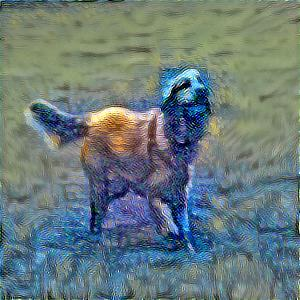

In [210]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
[u'model/Variable/Adadelta_2/Assign', u'model/Variable/Adadelta_3/Assign']
Iteration 0/100 Content L: 95924.6 Style L: 5.92313e+06 TV L: 36298.1 Total L: 6.05535e+06
Iteration 20/100 Content L: 93730 Style L: 4.35895e+06 TV L: 74433.3 Total L: 4.52711e+06
Iteration 40/100 Content L: 107721 Style L: 3.54936e+06 TV L: 74629.5 Total L: 3.73171e+06
Iteration 60/100 Content L: 127124 Style L: 1.34791e+06 TV L: 100801 Total L: 1.57584e+06
Iteration 80/100 Content L: 116881 Style L: 3.30062e+06 TV L: 77113.7 Total L: 3.49462e+06
Training took 16 seconds or 0.16 s/iteration !


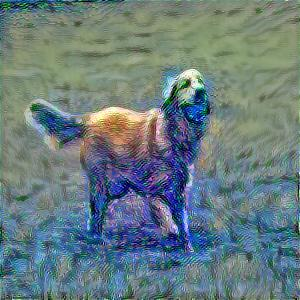

In [211]:
optimizer = tf.train.AdadeltaOptimizer(learning_rate=10)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
[u'model/Variable/Adagrad_1/Assign']
Iteration 0/100 Content L: 95952.7 Style L: 5.92252e+06 TV L: 36300.5 Total L: 6.05478e+06
Iteration 20/100 Content L: 120911 Style L: 1.44514e+06 TV L: 95717.8 Total L: 1.66177e+06
Iteration 40/100 Content L: 126405 Style L: 937262 TV L: 99930.7 Total L: 1.1636e+06
Iteration 60/100 Content L: 127817 Style L: 782854 TV L: 98535.2 Total L: 1.00921e+06
Iteration 80/100 Content L: 126841 Style L: 687015 TV L: 96211.4 Total L: 910067
Training took 16 seconds or 0.16 s/iteration !


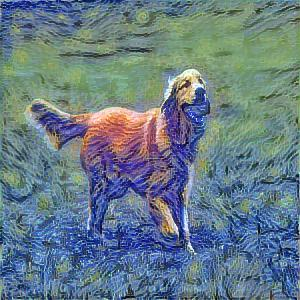

In [212]:
optimizer = tf.train.AdagradOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
[u'beta1_power_2/Assign', u'beta2_power_2/Assign', u'model/Variable/Adam_4/Assign', u'model/Variable/Adam_5/Assign']
Iteration 0/100 Content L: 95952.1 Style L: 5.92298e+06 TV L: 36294.7 Total L: 6.05523e+06
Iteration 20/100 Content L: 137054 Style L: 942329 TV L: 122529 Total L: 1.20191e+06
Iteration 40/100 Content L: 137122 Style L: 437533 TV L: 109423 Total L: 684078
Iteration 60/100 Content L: 129585 Style L: 347588 TV L: 96255.9 Total L: 573429
Iteration 80/100 Content L: 125551 Style L: 239423 TV L: 90248.4 Total L: 455222
Training took 16 seconds or 0.16 s/iteration !


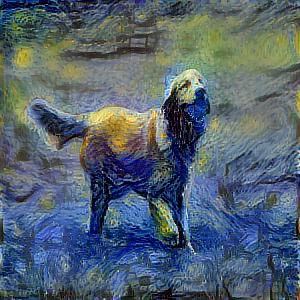

In [213]:
optimizer = tf.train.AdamOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

Uninitialized variables:
[u'model/Variable/RMSProp_2/Assign', u'model/Variable/RMSProp_3/Assign']
Iteration 0/100 Content L: 95955.9 Style L: 5.92232e+06 TV L: 36300.9 Total L: 6.05457e+06
Iteration 20/100 Content L: 110698 Style L: 2.43216e+06 TV L: 77310 Total L: 2.62017e+06
Iteration 40/100 Content L: 119349 Style L: 2.04016e+06 TV L: 87797.9 Total L: 2.24731e+06
Iteration 60/100 Content L: 126617 Style L: 1.88787e+06 TV L: 85329.9 Total L: 2.09981e+06
Iteration 80/100 Content L: 122501 Style L: 1.79192e+06 TV L: 87237.6 Total L: 2.00166e+06
Training took 16 seconds or 0.16 s/iteration !


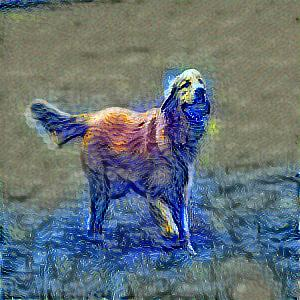

In [214]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
loss, result_image = optimize(optimizer)
save_results(optimizer.get_name(), loss, result_image)

### L-BFGS Optimizer

In tensorflow L-BFGS is just a wrapper around the python L-BFGS, just itself is 
a wrapper around a Fortran implementation of L-BFGS, so the procedure is a bit 
different than the other optimizers.

INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 249453.953125
  Number of iterations: 1001
  Number of functions evaluations: 1077


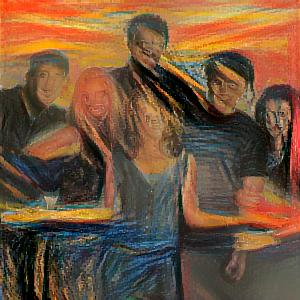

In [240]:
with graph.as_default():
    init_input()
    iterations = 1000
    
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
        score_op,
        var_list=[input_tensor],
        options={'maxiter': iterations})

    def step_callback(x):
        pass
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
#         x = x.astype('float32').reshape((1,) + image_size + (3,))
#         x = input_tensor.assign(tf.clip_by_value(x, 0, 255)).eval()
        # Show the image at this iteration
        # show(np.reshape(x, image_size + (3,)))

    def loss_callback(*args):
        wall_time = time.time() - start_time
        losses.append((wall_time, args[0]))

    losses = []
    start_time = time.time()

    optimizer.minimize(
        sess,
        #         feed_dict=[input_tensor],
        fetches=[score_op, style_loss_op, content_loss_op, tv_loss_op],
        step_callback=step_callback,
        loss_callback=loss_callback
    )

    result_image = input_tensor.eval()
    result_image = np.clip(deprocess(result_image), 0, 255)
    show(result_image)
    save_results('L-BFGS', losses, result_image)

### Compare the Optimizers

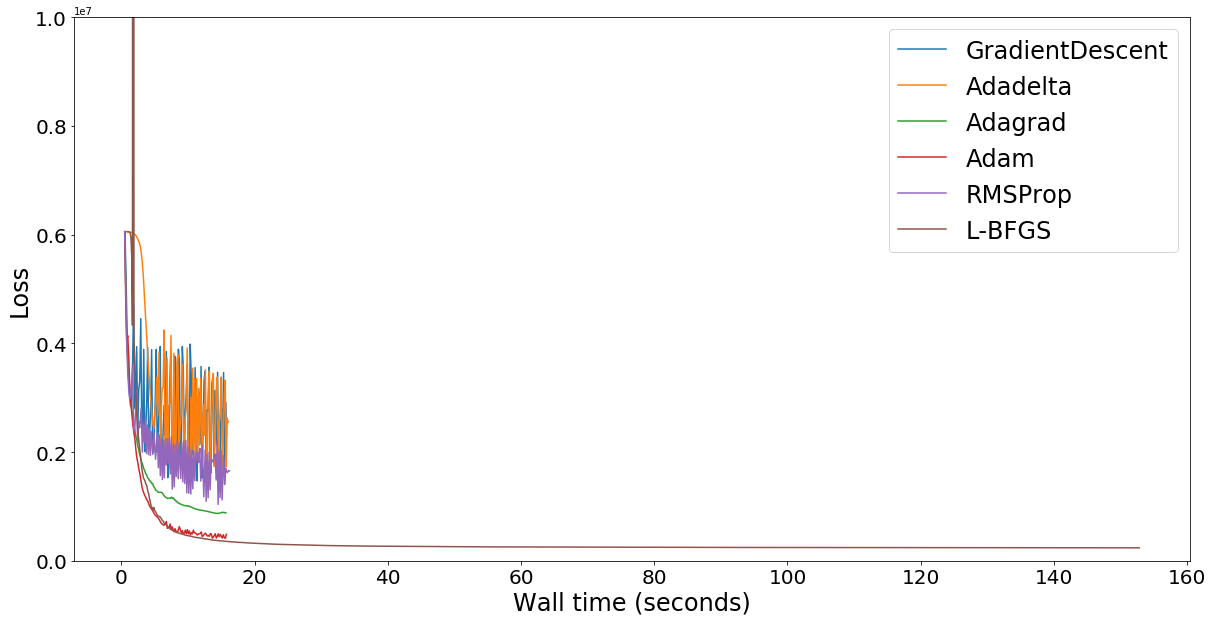

In [216]:
figure.set_size_inches(20, 10, forward=True)
plt.legend(plotHandles, labels, prop={'size': 24})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tick_params(labelsize=20)
plt.xlabel('Wall time (seconds)', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.ylim([0, 1e+7])

figure

## Gradient Descent by hand
We can do the gradient descent by hand, to gain a better understanding of it.

In [ ]:
with graph.as_default():
    # This might need to be lower.
    learning_rate = 10

    # Recommended at least 500 - 1000 iterations for a good quality image.
    # Good style should be visible even after 100 iters.
    iterations = 500

    # How many times to print the progress
    print_n_times = 5
    print_every_n = max(iterations // print_n_times, 1)

    # To compute total optimization time
    start_time = time.time()

    # To display average losses
    content_losses = []
    style_losses = []
    tv_losses = []
    # Run the optimization
    for i in range(iterations):
        (gradient_computed, score_computed,
         style_loss_computed, content_loss_computed,
         tv_loss_computed) = sess.run(
            [gradient_op, score_op, style_loss_op, content_loss_op,
             tv_loss_op],
            feed_dict={input_tensor: result_image})

        # Modify the current image by the gradient
        result_image -= gradient_computed * learning_rate

        # Clip for better quality image
        result_image = np.clip(result_image, 0, 256)

        # Store the losses to display
        content_losses.append(content_loss_computed)
        style_losses.append(style_loss_computed)
        tv_losses.append(tv_loss_computed)

        # Print losses
        if (i % print_every_n == 0):
            print('Iteration: %d Loss: %g  Style L: %g  Content L: %g TV L: %g' %
                  (i,
                   score_computed,
                   np.asarray(style_losses).mean(),
                   np.asarray(content_losses).mean(),
                   np.asarray(tv_losses).mean()))
            content_losses = []
            style_losses = []
            tv_losses = []

In [ ]:
# Show what we got
show(np.squeeze(deprocess(result_image)))